# Classification fine-tuning using Helical

## Cell type classification task

In [ ]:
from helical.utils import get_anndata_from_hf_dataset
from helical import Geneformer, GeneformerConfig, GeneformerFineTuningModel, scGPT, scGPTConfig, scGPTFineTuningModel, UCE, UCEConfig, UCEFineTuningModel
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import logging, warnings

logging.getLogger().setLevel(logging.ERROR)

warnings.filterwarnings("ignore")

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Install datasets

In [ ]:
from datasets import load_dataset
ds = load_dataset("helical-ai/yolksac_human",trust_remote_code=True, download_mode="reuse_cache_if_exists")

In [4]:
train_dataset = get_anndata_from_hf_dataset(ds["train"])
test_dataset = get_anndata_from_hf_dataset(ds["test"])

## Prepare training labels

- For this classification task we want to predict cell type classes
- So we save the cell types as a list

In [5]:
cell_types_train = list(np.array(train_dataset.obs["LVL1"].tolist()))
cell_types_test = list(np.array(test_dataset.obs["LVL1"].tolist()))

- We convert these string labels into unique integer classes for training

In [6]:
label_set = set(cell_types_train) | set(cell_types_test)
class_id_dict = dict(zip(label_set, [i for i in range(len(label_set))]))
id_class_dict = {v: k for k, v in class_id_dict.items()}

for i in range(len(cell_types_train)):
    cell_types_train[i] = class_id_dict[cell_types_train[i]]

for i in range(len(cell_types_test)):
    cell_types_test[i] = class_id_dict[cell_types_test[i]]



## Geneformer Fine-Tuning

Load the desired pretrained Geneformer model and desired configs

In [7]:
geneformer_config = GeneformerConfig(device=device, batch_size=10, model_name="gf-6L-30M-i2048")
geneformer = Geneformer(configurer = geneformer_config)

Process the data so it is in the correct form for Geneformer

In [ ]:
geneformer_train_dataset = geneformer.process_data(train_dataset)
geneformer_test_dataset = geneformer.process_data(test_dataset)

Geneformer makes use of the Hugging Face dataset class and so we need to add the labels as a column to this dataset

In [9]:
geneformer_train_dataset = geneformer_train_dataset.add_column("LVL1", cell_types_train)
geneformer_test_dataset = geneformer_test_dataset.add_column("LVL1", cell_types_test)

Define the Geneformer Fine-Tuning Model from the Helical package which appends a fine-tuning head automatically from the list of available heads
- Define the task type, which in this case is classification
- Defined the output size, which is the number of unique labels for classification

In [10]:
geneformer_fine_tune = GeneformerFineTuningModel(geneformer_model=geneformer, fine_tuning_head="classification", output_size=len(label_set))

Fine-tune the model

In [12]:
geneformer_fine_tune.train(train_dataset=geneformer_train_dataset.shuffle(), validation_dataset=geneformer_test_dataset, label="LVL1", freeze_layers=0, epochs=1, optimizer_params={"lr": 1e-4}, lr_scheduler_params={"name":"linear", "num_warmup_steps":0, 'num_training_steps':1})

Fine-Tuning Validation: 100%|██████████| 634/634 [00:44<00:00, 14.23it/s, accuracy=0.988]


In [13]:
outputs = geneformer_fine_tune.get_outputs(geneformer_test_dataset)

Generating Outputs: 100%|██████████| 634/634 [00:43<00:00, 14.72it/s]


In [14]:
print(classification_report(cell_types_test,outputs.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.31      0.58      0.40        19
           1       0.99      1.00      1.00      3001
           2       0.99      0.97      0.98       938
           3       1.00      1.00      1.00      2321
           4       0.88      0.92      0.90        38
           5       0.60      0.47      0.53        19

    accuracy                           0.99      6336
   macro avg       0.79      0.82      0.80      6336
weighted avg       0.99      0.99      0.99      6336



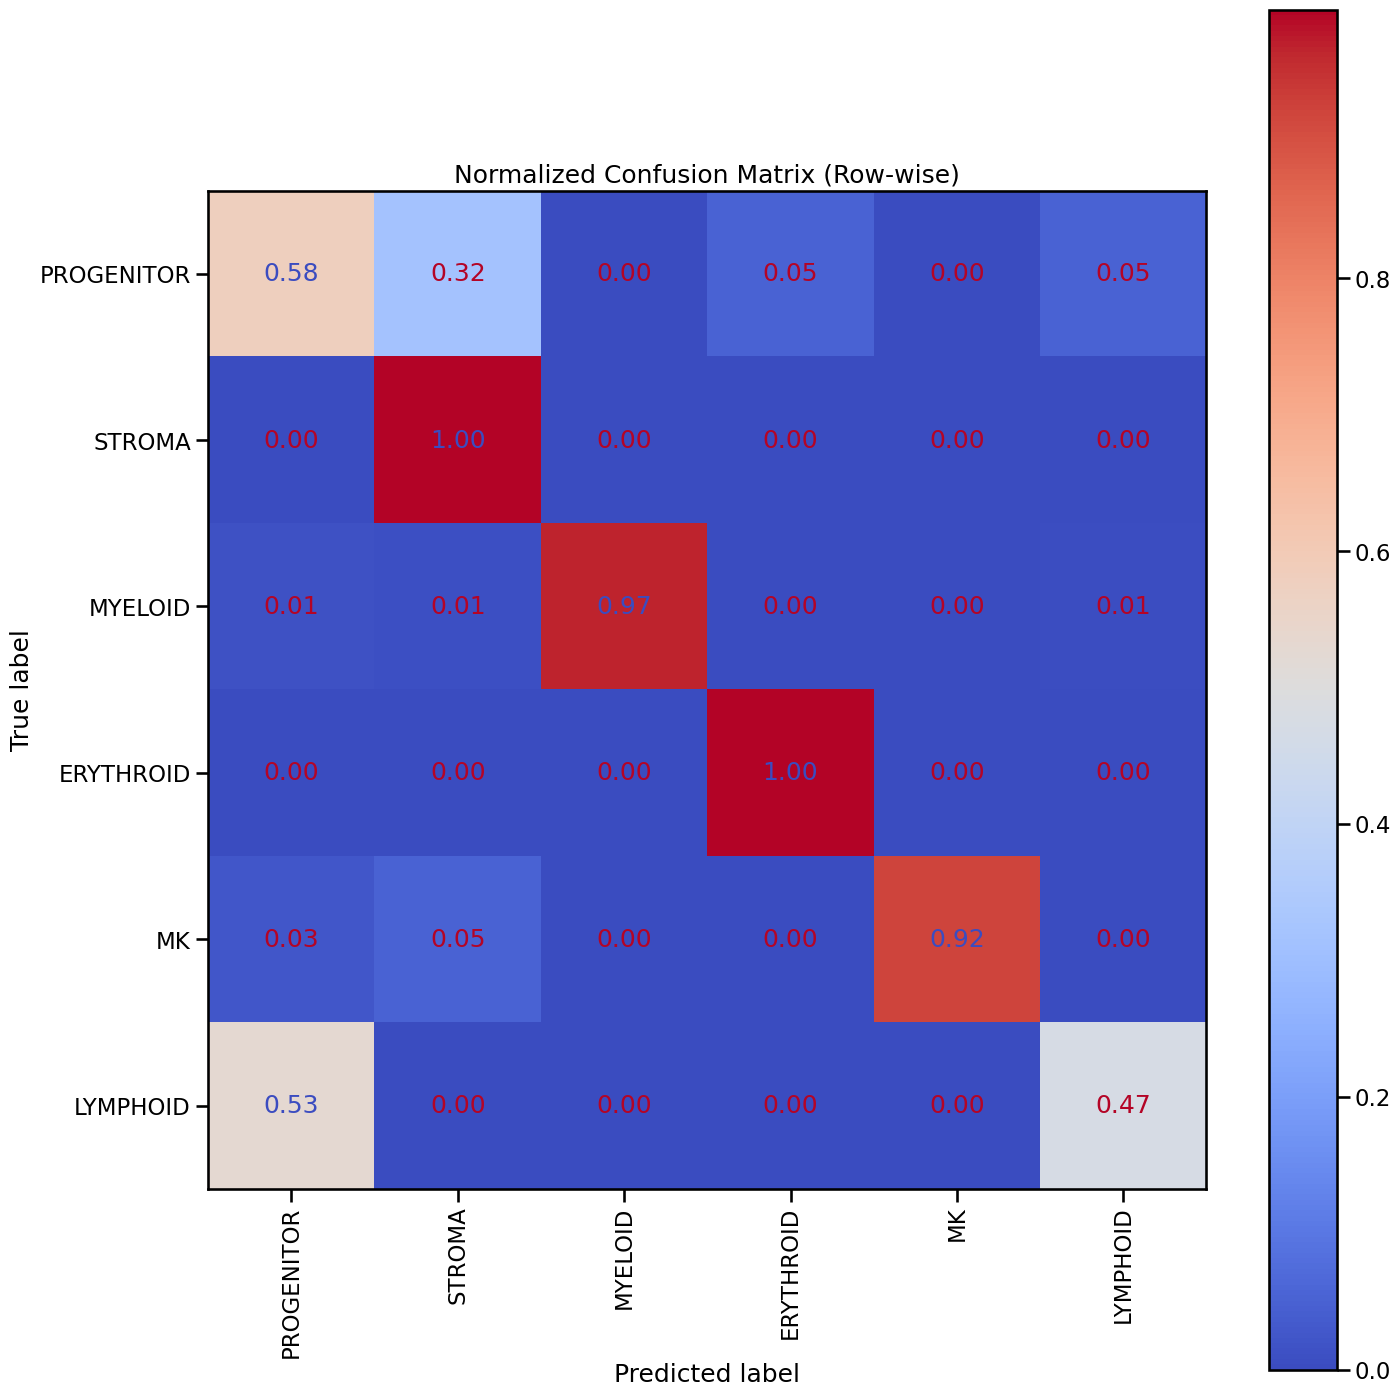

In [15]:
# Compute the confusion matrix
cm = confusion_matrix(cell_types_test, outputs.argmax(axis=1))

# Perform row-wise normalization
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Get unique labels in the order they appear in the confusion matrix
unique_labels = np.unique(np.concatenate((cell_types_test, outputs.argmax(axis=1))))

# Use id_class_dict to get the class names
class_names = [id_class_dict[label] for label in unique_labels]

# Create and plot the normalized confusion matrix
fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp.plot(ax=ax, xticks_rotation='vertical', values_format='.2f', cmap='coolwarm')

# Customize the plot
ax.set_title('Normalized Confusion Matrix (Row-wise)')
fig.set_facecolor("none")

plt.tight_layout()
plt.show()

## scGPT Fine-Tuning

Now the same procedure with scGPT
- Loading the model and setting desired configs

In [16]:
scgpt_config=scGPTConfig(batch_size=20, device=device)
scgpt = scGPT(configurer=scgpt_config)

A slightly different methodology for getting the dataset for scGPT since it does not make use of the Hugging Face Dataset class
- Split the data into a train and validation set

In [17]:
dataset = scgpt.process_data(train_dataset, gene_names = "gene_name")
validation_dataset = scgpt.process_data(test_dataset, gene_names = "gene_name")

Define the scGPT fine-tuning model with the desired head and number of classes

In [18]:
scgpt_fine_tune = scGPTFineTuningModel(scGPT_model=scgpt, fine_tuning_head="classification", output_size=len(label_set))

For scGPT fine tuning we have to pass in the labels as a separate list
- This is the same for the validation and training sets

In [19]:
scgpt_fine_tune.train(train_input_data=dataset, train_labels=cell_types_train, validation_input_data=validation_dataset, validation_labels=cell_types_test, epochs=1, optimizer_params={"lr": 2e-5}, lr_scheduler_params={"name":"linear", "num_warmup_steps":0, 'num_training_steps':1})

Fine-Tuning Validation: 100%|██████████| 317/317 [00:37<00:00,  8.37it/s, accuracy=0.991]


In [20]:
outputs = scgpt_fine_tune.get_outputs(validation_dataset)

Fine-Tuning Validation: 100%|██████████| 317/317 [00:35<00:00,  9.01it/s]


In [21]:
print(classification_report(cell_types_test,outputs.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.67      0.21      0.32        19
           1       0.99      1.00      1.00      3001
           2       0.98      0.99      0.98       938
           3       1.00      1.00      1.00      2321
           4       0.84      0.97      0.90        38
           5       0.78      0.74      0.76        19

    accuracy                           0.99      6336
   macro avg       0.88      0.82      0.83      6336
weighted avg       0.99      0.99      0.99      6336



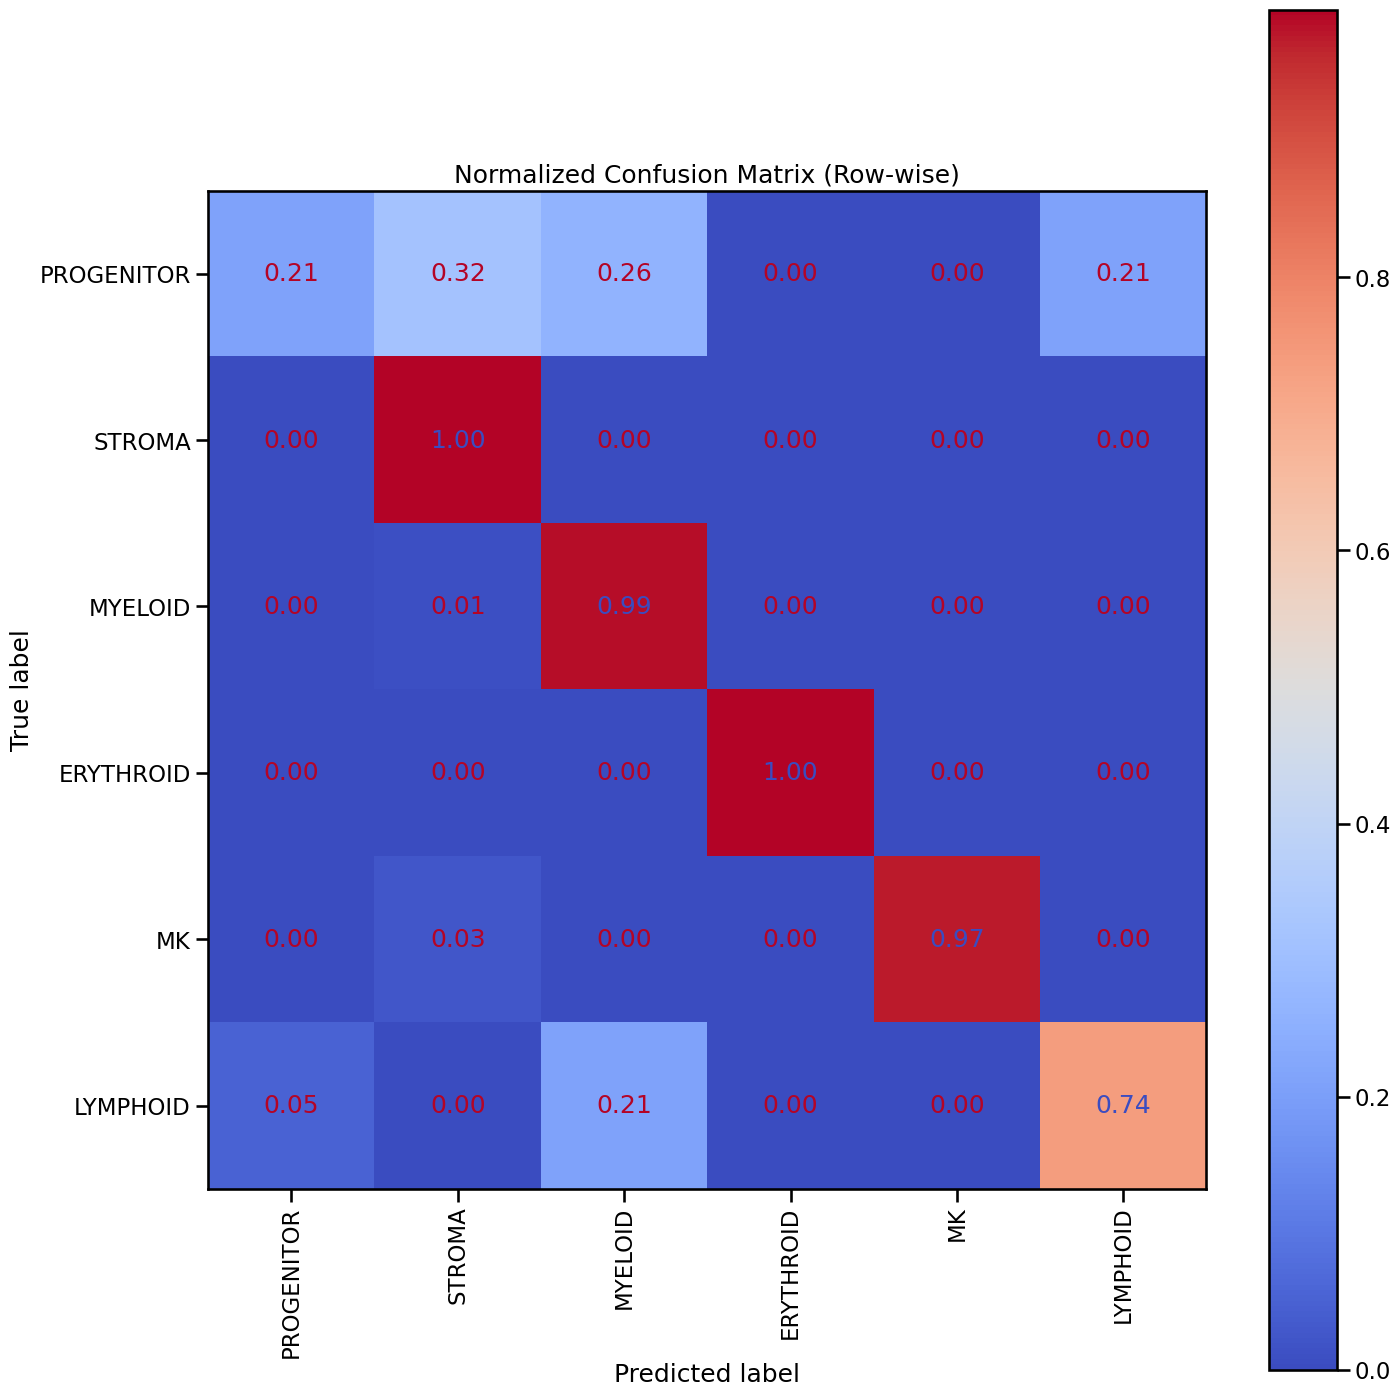

In [22]:
# Compute the confusion matrix
cm = confusion_matrix(cell_types_test, outputs.argmax(axis=1))

# Perform row-wise normalization
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Get unique labels in the order they appear in the confusion matrix
unique_labels = np.unique(np.concatenate((cell_types_test, outputs.argmax(axis=1))))

# Use id_class_dict to get the class names
class_names = [id_class_dict[label] for label in unique_labels]

# Create and plot the normalized confusion matrix
fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp.plot(ax=ax, xticks_rotation='vertical', values_format='.2f', cmap='coolwarm')

# Customize the plot
ax.set_title('Normalized Confusion Matrix (Row-wise)')
fig.set_facecolor("none")

plt.tight_layout()
plt.show()
